# 主力籌碼影響價格分析

本篇主要分析三大主力:

1. 外資
2. 投信
3. 自營商

三個主力分別對於市場價格有甚麼影響

## 會使用到的 Function

In [23]:
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import requests

從 yfinance 下載股價資訊

In [24]:
def get_stock_from_yf(stock_code, start_date, end_date):
    # 獲取股價數據
    yf_df = yf.download(stock_code, start=start_date, end=end_date)

    # 計算價格百分比成長率
    price_pct_groth = yf_df['Close'].pct_change().fillna(0)
    yf_df["price_cum_growth"] = (1 + price_pct_groth).cumprod() - 1
    return yf_df

三個 function 用來儲存法人資訊 :
1. 從 TWSE 抓取股票的法人資訊
2. 儲存抓取的 dataframe
3. 從儲存好的 csv 讀取資料

In [25]:
def get_mi_movement_from_twse(start_date:str, end_date:str, stock_code:list[str]) -> dict[str:pd.DataFrame]:

    """Get major investors movements dataframe during date"""

    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    result_dict = {}
    for code in stock_code:
        result_dict[code] = pd.DataFrame()
    fail_list = []
    current_date = start
    while current_date <= end:
        try:
            date_str = current_date.strftime("%Y%m%d")
            
            url = f"https://www.twse.com.tw/rwd/zh/fund/T86?response=json&date={date_str}&selectType=ALL"
            response = requests.get(url)
            data = response.json()
            
            if "data" in data:
                df = pd.DataFrame(data["data"], columns=data["fields"])
                for code in stock_code:
                    df_filtered = df[df["證券代號"].astype(str) == code].copy()
                    df_filtered.loc[:, "日期"] = current_date.strftime("%Y-%m-%d")
                    result_dict[code] = pd.concat([result_dict[code], df_filtered], ignore_index=True)
        except:
            fail_list.append(current_date)
            print(f"該日缺失:{current_date}")
        
        current_date += timedelta(days=1)

    while fail_list:
        try:
            current_date = fail_list[0]
            print(f"重新抓取 : {current_date} 資料")
            date_str = current_date.strftime("%Y%m%d")
            url = f"https://www.twse.com.tw/rwd/zh/fund/T86?response=json&date={date_str}&selectType=ALL"
            response = requests.get(url)
            data = response.json()
            if "data" in data:
                df = pd.DataFrame(data["data"], columns=data["fields"])
                for code in stock_code:
                    df_filtered = df[df["證券代號"].astype(str) == code].copy()
                    df_filtered.loc[:, "日期"] = current_date.strftime("%Y-%m-%d")
                    result_dict[code] = pd.concat([result_dict[code], df_filtered], ignore_index=True)
                fail_list.pop(0)
        except:
            print(f"該日缺失:{current_date}")
    return result_dict

def save_mi_movement_to_csv(df_dict:dict[str:pd.DataFrame]) -> None:

    """Save major investors movements dataframe to csv"""
    
    stock_code = list(df_dict.keys())
    for code in stock_code:
        df_dict[code].to_csv(f"../mi_movements_csv/{code}_mi_movement.csv", encoding="utf-8", index=False)
        print(f"Save to : ../mi_movements_csv/{code}_mi_movement.csv")
    return

def read_mi_movement_from_csv(file_path:str, start_date:str, end_date:str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df.set_index('日期', inplace=True)
    df.rename_axis('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    df = df[df.index <= end_date]
    df = df[start_date <= df.index ]
    return df

從 TWSE 爬取到的個股法人資訊中，我們需要需要使用的 column 分別是
1. 外陸資買賣超股數(不含外資自營商) : 代表外資
2. 投信買賣超股數 : 代表投信
3. 自營商買賣超股數(自行買賣) : 代表自營商
4. 三大法人買賣超股數 : 三家加總

In [26]:
def data_pretreatment(mi_df):
    mi_df.index = pd.to_datetime(mi_df.index)

    scaler = StandardScaler()
    standard_weight = 0.006
    # 換算三大法人累計買賣超
    mi_df["外陸資買賣超股數(不含外資自營商)"] = mi_df["外陸資買賣超股數(不含外資自營商)"].replace('[\$,]', '', regex=True).astype(int)
    mi_df["外資買賣超標準化"] = scaler.fit_transform(mi_df["外陸資買賣超股數(不含外資自營商)"].values.reshape(-1, 1))
    mi_df["外資累計買賣超"] = mi_df["外資買賣超標準化"].cumsum() * standard_weight

    mi_df["投信買賣超股數"] = mi_df["投信買賣超股數"].replace('[\$,]', '', regex=True).astype(int)
    mi_df["投信買賣超標準化"] = scaler.fit_transform(mi_df["投信買賣超股數"].values.reshape(-1, 1))
    mi_df["投信累計買賣超"] = mi_df["投信買賣超標準化"].cumsum() * standard_weight

    mi_df["自營商買賣超股數"] = mi_df["自營商買賣超股數"].replace('[\$,]', '', regex=True).astype(int)
    mi_df["自營商買賣超標準化"] = scaler.fit_transform(mi_df["自營商買賣超股數"].values.reshape(-1, 1))
    mi_df["自營商累計買賣超"] = mi_df["自營商買賣超標準化"].cumsum() * standard_weight

    mi_df["三大法人買賣超股數"] = mi_df["三大法人買賣超股數"].replace('[\$,]', '', regex=True).astype(int)
    mi_df["三大法人買賣超標準化"] = scaler.fit_transform(mi_df["三大法人買賣超股數"].values.reshape(-1, 1))
    mi_df["三大法人累計買賣超"] = mi_df["三大法人買賣超標準化"].cumsum() * standard_weight

    gi_parm = 0.7
    si_parm = 0.2
    sd_parm = 0.1
    mi_df["三大法人累計買賣超權重"] =  mi_df["外資累計買賣超"] * gi_parm + mi_df["投信累計買賣超"] * si_parm + mi_df["自營商累計買賣超"] * sd_parm
    return mi_df

圖表 function

In [27]:
def graph_analysis(yf_df, mi_df):
    fig, axes = plt.subplots(3, 2, figsize=(14, 8))

    axes[0, 0].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
    axes[0, 0].plot(mi_df.index, mi_df["外資累計買賣超"] , color='blue', label='Global investment')
    axes[0, 0].set_title('Global investment')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
    axes[0, 1].plot(mi_df.index, mi_df["投信累計買賣超"] , color='blue', label='Securities investment')
    axes[0, 1].set_title('Securities investment')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 0].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
    axes[1, 0].plot(mi_df.index, mi_df["自營商累計買賣超"] , color='blue', label='Self-dealer investment')
    axes[1, 0].set_title('Self-dealer investment')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    axes[1, 1].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
    axes[1, 1].plot(mi_df.index, mi_df["三大法人累計買賣超"] , color='blue', label='Three major corporations')
    axes[1, 1].set_title('Three major corporations')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    axes[2, 0].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
    axes[2, 0].plot(mi_df.index, mi_df["三大法人累計買賣超權重"] * 3 , color='blue', label='Three major corporations')
    axes[2, 0].set_title('Three major corporations with weight')
    axes[2, 0].legend()
    axes[2, 0].grid(True)

    fig.delaxes(axes[2, 1])
    plt.tight_layout()
    plt.show()

檢測 correlation 相關係數

In [28]:
def correlation(stock_df, mi_df):
    gi_cor = stock_df["price_cum_growth"].corr(mi_df['外資累計買賣超'])
    si_cor = stock_df["price_cum_growth"].corr(mi_df['投信累計買賣超'])
    sd_cor = stock_df["price_cum_growth"].corr(mi_df['自營商累計買賣超'])
    tm_cor = stock_df["price_cum_growth"].corr(mi_df['三大法人累計買賣超'])
    tmw_cor = stock_df["price_cum_growth"].corr(mi_df['三大法人累計買賣超權重'])
    print(f'Global investment Correlation: {gi_cor:.3f}')
    print(f'Securities investment Correlation: {si_cor:.3f}')
    print(f'Self-dealer Correlation: {sd_cor:.3f}')
    print(f'Three major corporations Correlation: {tm_cor:.3f}')
    print(f'Three major corporations with weight Correlation: {tmw_cor:.3f}')

## 範例使用方法
### 匯入股價資訊
從 yfinance 匯入股價資訊

In [9]:
# 定義股票代碼和日期範圍
stock_code = "2330.TW"
start_date = "2021-01-01"
end_date = "2024-06-26"
yf_df = get_stock_from_yf(stock_code, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


### 匯入主力籌碼變化

從 TWSE 抓取該股的每日主力買賣資訊，一次大約需要22分鐘左右

In [18]:
stock_code = ["2330"]

mi_dict = get_mi_movement_from_twse(start_date=start_date, end_date=end_date, stock_code=stock_code)

將抓取的資訊存成 csv 檔，後續就不用重新抓耗費太多時間

> TODO : 後續的每日買賣超可以透過 cron job 對直接 concat 到儲存好的 csv

In [19]:
save_mi_movement_to_csv(df_dict=mi_dict)

從下載好的資料讀取 dataframe

In [33]:
stock_code = "2330"
file_path = f"../mi_movements_csv/{stock_code}_mi_movement.csv"
mi_df = read_mi_movement_from_csv(file_path=file_path, start_date='2020-01-01', end_date='2024-06-26')


處理法人數據

In [30]:
mi_df = data_pretreatment(mi_df)

顯示圖表

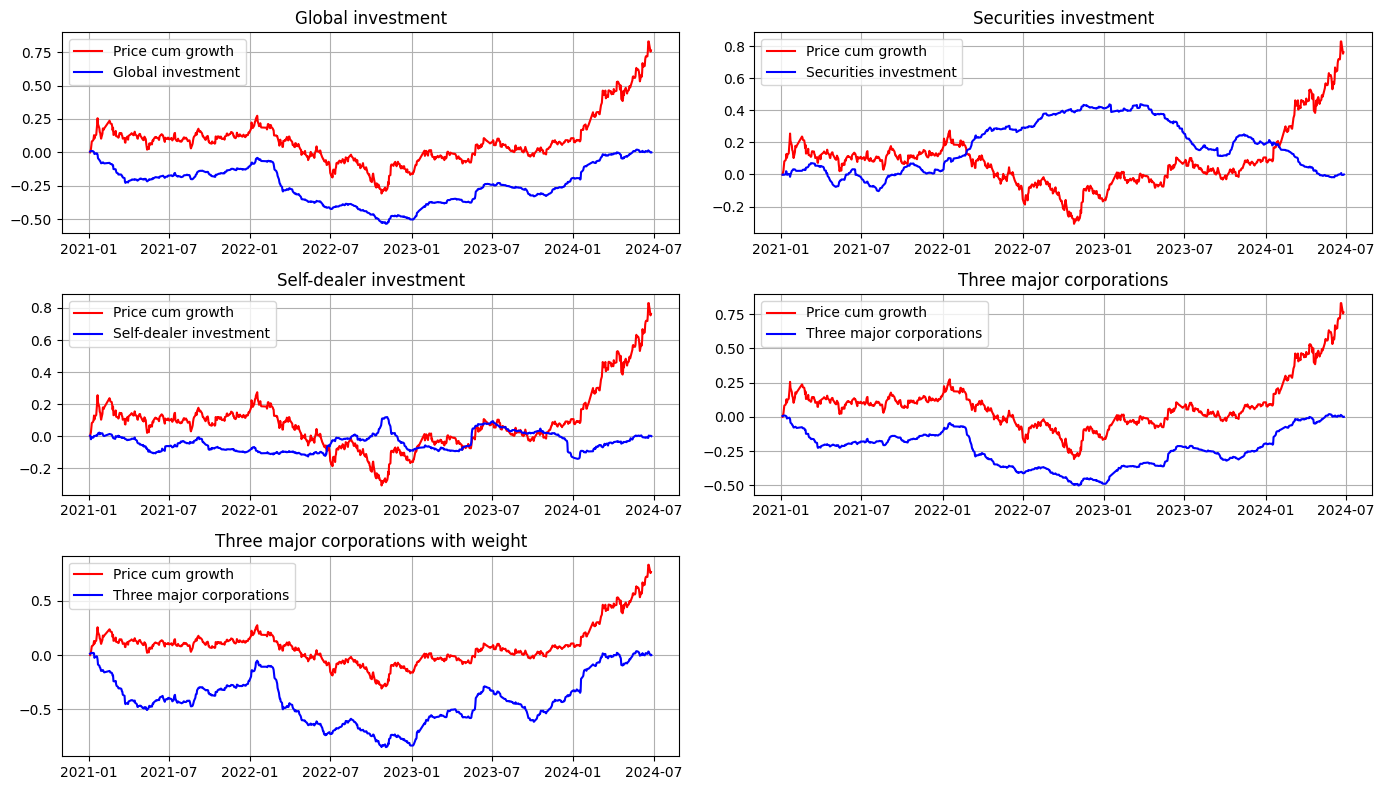

In [13]:
graph_analysis(yf_df, mi_df)

分析相關係數

In [14]:
correlation(yf_df, mi_df)

Global investment Correlation: 0.876
Securities investment Correlation: -0.653
Self-dealer Correlation: -0.091
Three major corporations Correlation: 0.880
Three major corporations with weight Correlation: 0.887


# 自動化產生圖表以及數據

### 1. 下載法人資訊
從 TWSE 下載資料，如果已經下載過了可以直接到下一步

In [ ]:
stock_code = ["2330.TW"]
# TWSE 最早時間只有從 2012-05-02 開始，2018-01-02 之後的格式有變動，所以以 2018-01-02 為開始
start_date = "2018-01-02"
end_date = "2024-06-26"
for i in range(len(stock_code)):
    stock_code[i] = stock_code[i].split(".")[0]
mi_dict = get_mi_movement_from_twse(start_date=start_date, end_date=end_date, stock_code=stock_code)
save_mi_movement_to_csv(df=mi_dict, stock_code=stock_code)

### 2. 從下載好的檔案和 yfinance 讀取資料
設定想觀察的起始日期與股票代碼，從 yfinance 讀取區間價格

In [42]:
stock_code = "2330.TW"
start_date = "2021-01-01"
end_date = "2024-06-26"
yf_df = get_stock_from_yf(stock_code, start_date, end_date)
# 從有價格開始的日期設為 start_date
start_date = yf_df.index[0].strftime('%Y-%m-%d')
print(f"股票區間從 {start_date} ~ {end_date}")

[*********************100%%**********************]  1 of 1 completed

股票區間從 2021-01-04 ~ 2024-06-26


從 csv 讀取法人資訊

In [43]:
stock_code = stock_code.split(".")[0]
file_path = f"../mi_movements_csv/{stock_code}_mi_movement.csv"
mi_df = read_mi_movement_from_csv(file_path=file_path, start_date=start_date, end_date=end_date)

### 3. 觀察圖表
觀察圖形和相關係數

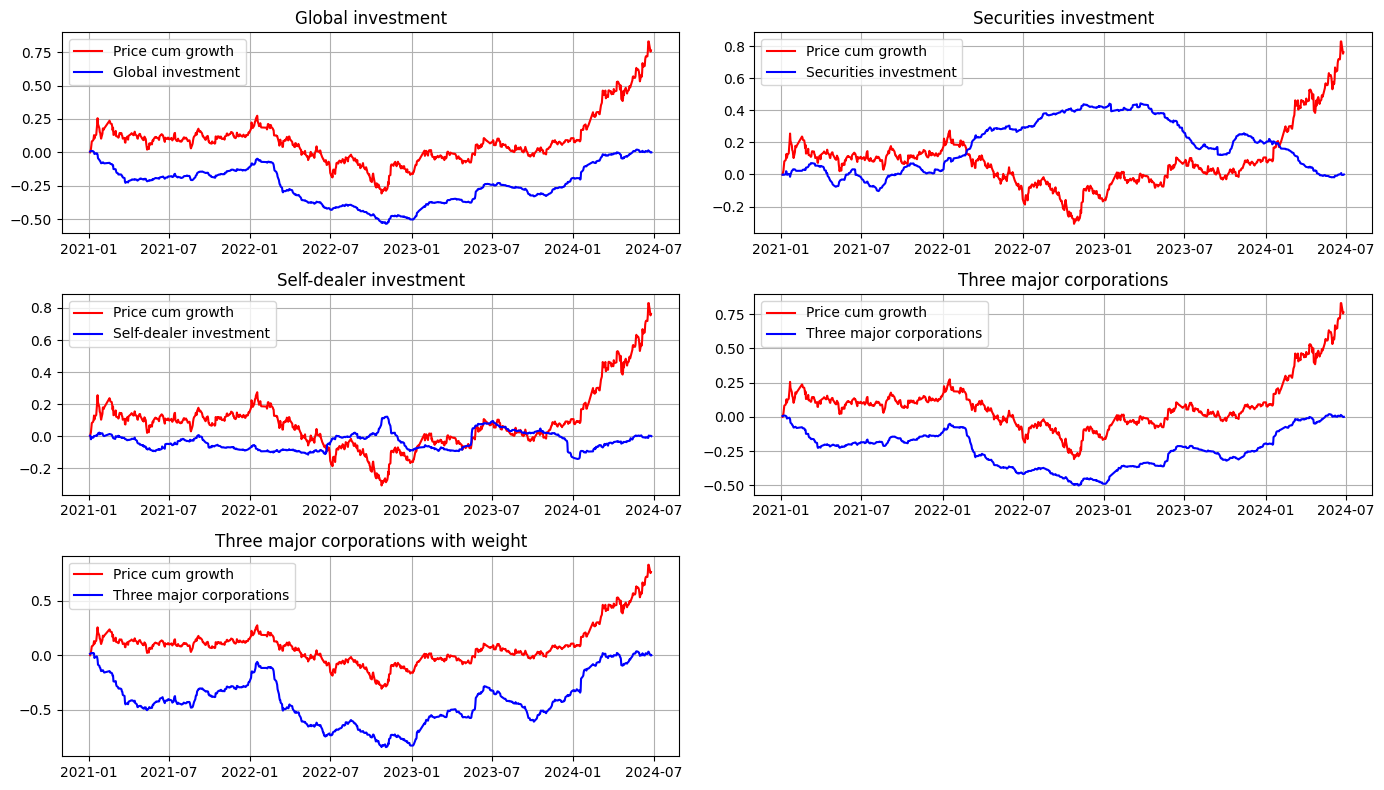

Global investment Correlation: 0.878
Securities investment Correlation: -0.652
Self-dealer Correlation: -0.114
Three major corporations Correlation: 0.882
Three major corporations with weight Correlation: 0.887


In [44]:
midf = data_pretreatment(mi_df)
graph_analysis(yf_df, mi_df)
correlation(yf_df, mi_df)

# 問題與反思

### 1. 數據問題

做比對的數據分別是用 <span style="color: #F85557;">股票的百分比成長率</span> 和 <span style="color: #326CFF;">法人買賣累計股數</span>，<span style="color: #326CFF;">法人買賣累計股數</span> 的處理是對法人買賣股數進行標準化之後轉換成累加數據後再乘上 0.006。對於買賣累計股數以常理來說應該是很少採取 hold and buy 的策略，因此交易的數值不會超過太大，長久來看都會在 0 附近徘徊，因此需要思考哪一種數據能很好的反應法人的行動，並且能隨著股價成長。

### 2. 時間問題

如何選定適合的時間區間是必要的討論問題，若將時間拉得太長，就會如第一點所說的線型沒有辦法很好的匹配股價成長率，並且對於法人的短期投資按常理來說會影響一小段的價格，但是不一定會影響全部的股價。
例如，一支股票價格為 10 塊，法人進行了投資並且於 20 塊時獲利結束全部出清，但是這個出清並不一定會讓股價退回 10 塊，因此這些每一小段的差距隨著時間拉長就會造成誤差，因此研究如何選擇適合的時間區間是很重要的。
